## Mobilenet architecture for mobile devices

In [ ]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


from torchvision import datasets, models, transforms
from torchsummary import summary
from datetime import datetime

!pip3 install torchviz
from torchviz import make_dot

### 1) Linear BottleNeck

In [ ]:
class LinearBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, stride, t=6, class_num=100):
        super().__init__()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, 1),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),

            nn.Conv2d(in_channels * t, in_channels * t, 3, stride=stride, padding=1, groups=in_channels * t),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),

            nn.Conv2d(in_channels * t, out_channels, 1),
            nn.BatchNorm2d(out_channels)
        )

        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

    def forward(self, x):

        residual = self.residual(x)

        if self.stride == 1 and self.in_channels == self.out_channels:
            residual += x

        return residual


## Architecture

In [ ]:
class MobileNetV2(nn.Module):

    def __init__(self, class_num=10):
        super().__init__()

        self.pre = nn.Sequential(
            nn.Conv2d(3, 32, 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.stage1 = LinearBottleNeck(32, 16, 1, 1)
        self.stage2 = self._make_stage(2, 16, 24, 2, 6)
        self.stage3 = self._make_stage(3, 24, 32, 2, 6)
        self.stage4 = self._make_stage(4, 32, 64, 2, 6)
        self.stage5 = self._make_stage(3, 64, 96, 1, 6)
        self.stage6 = self._make_stage(3, 96, 160, 1, 6)
        self.stage7 = LinearBottleNeck(160, 320, 1, 6)

        self.conv1 = nn.Sequential(
            nn.Conv2d(320, 1280, 1),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        self.conv2 = nn.Conv2d(1280, class_num, 1)

    def forward(self, x):
        x = self.pre(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.conv1(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = self.conv2(x)
        logits = x.view(x.size(0), -1)
        probs = F.softmax(logits, dim=1)
        return logits, probs

    def _make_stage(self, repeat, in_channels, out_channels, stride, t):

        layers = []
        layers.append(LinearBottleNeck(in_channels, out_channels, stride, t))

        while repeat - 1:
            layers.append(LinearBottleNeck(out_channels, out_channels, 1, t))
            repeat -= 1

        return nn.Sequential(*layers)

In [ ]:
net = MobileNetV2()
print(net)

MobileNetV2(
  (pre): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (stage1): LinearBottleNeck(
    (residual): Sequential(
      (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU6(inplace=True)
      (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage2): Sequential(
    (0): LinearBottleNeck(
      (residual): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
net = net.to(device)
torch.cuda.is_available()

True

In [ ]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 34, 34]             128
       BatchNorm2d-2           [-1, 32, 34, 34]              64
             ReLU6-3           [-1, 32, 34, 34]               0
            Conv2d-4           [-1, 32, 34, 34]           1,056
       BatchNorm2d-5           [-1, 32, 34, 34]              64
             ReLU6-6           [-1, 32, 34, 34]               0
            Conv2d-7           [-1, 32, 34, 34]             320
       BatchNorm2d-8           [-1, 32, 34, 34]              64
             ReLU6-9           [-1, 32, 34, 34]               0
           Conv2d-10           [-1, 16, 34, 34]             528
      BatchNorm2d-11           [-1, 16, 34, 34]              32
 LinearBottleNeck-12           [-1, 16, 34, 34]               0
           Conv2d-13           [-1, 96, 34, 34]           1,632
      BatchNorm2d-14           [-1, 96,

## Data preparation

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
train_set = torchvision.datasets.CIFAR10('./datasets', train=True, 
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False, 
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, 
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, 
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


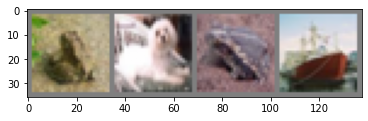

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [ ]:
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
epochs = 20

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay,  nesterov=True)

### Training

In [ ]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [ ]:

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
model, optimizer, _ = training_loop(net, criterion, optimizer, train_loader, test_loader, epochs, device)

07:31:07 --- Epoch: 0	Train loss: 2.0404	Valid loss: 1.7507	Train accuracy: 31.81	Valid accuracy: 32.34
07:31:58 --- Epoch: 1	Train loss: 1.6364	Valid loss: 1.5305	Train accuracy: 42.06	Valid accuracy: 42.40
07:32:49 --- Epoch: 2	Train loss: 1.4607	Valid loss: 1.4038	Train accuracy: 48.76	Valid accuracy: 47.48
07:33:41 --- Epoch: 3	Train loss: 1.3459	Valid loss: 1.3162	Train accuracy: 53.17	Valid accuracy: 51.07
07:34:33 --- Epoch: 4	Train loss: 1.2574	Valid loss: 1.2336	Train accuracy: 57.03	Valid accuracy: 54.46
07:35:25 --- Epoch: 5	Train loss: 1.1711	Valid loss: 1.1661	Train accuracy: 60.69	Valid accuracy: 57.48
07:36:17 --- Epoch: 6	Train loss: 1.0961	Valid loss: 1.1265	Train accuracy: 62.93	Valid accuracy: 59.16
07:37:09 --- Epoch: 7	Train loss: 1.0287	Valid loss: 1.0650	Train accuracy: 66.45	Valid accuracy: 61.75
07:38:01 --- Epoch: 8	Train loss: 0.9632	Valid loss: 1.0408	Train accuracy: 68.00	Valid accuracy: 62.94
07:38:52 --- Epoch: 9	Train loss: 0.9141	Valid loss: 1.0364	Trai